# ResNet RGB

In [1]:
%pip install lightning polars
%pip install tqdm
%pip install --upgrade torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import polars as pl
import numpy as np
import lightning as L
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Model imports
# from torchvision.transforms import v2

# Metrics imports
from torchmetrics import (
    Accuracy,
    F1Score,
    AUROC,
    ConfusionMatrix,
    Precision,
    Recall
)

# Lightning modules and callbacks
from lightning.pytorch.callbacks import (
    ModelCheckpoint,
    EarlyStopping
)
from pytorch_lightning.loggers import TensorBoardLogger

import torchvision.models as models
import pytorch_lightning as L
# from torchvision.models import resnet18
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
# from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as v2

# Set random seeds for reproducibility
# import random
# torch.manual_seed(42)
# np.random.seed(42)
# random.seed(42)

In [3]:
print("GPU available:", torch.cuda.is_available())

GPU available: True


In [4]:
class ImageDataset(torch.utils.data.Dataset):
    """Dataset for loading and preprocessing garbage classification images."""

    def __init__(self, dataframe: pl.DataFrame, training=False, img_size=224):
        super().__init__()
        # Use the image_path column directly from the dataframe as it now contains full paths
        # to the preprocessed RGB images
        self.image_path = dataframe['image_path'].to_numpy().squeeze()
        self.garbage_type = dataframe.select('label').to_numpy().squeeze()
        self.garbage_to_idx = {garbage: i for i, garbage in enumerate(np.unique(self.garbage_type))}
        self.training = training
        self.img_size = img_size

        # Enhanced augmentation for training - can be simpler now since images are already preprocessed
        self.train_transforms = v2.Compose([
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomVerticalFlip(p=0.3),
            v2.RandomRotation(degrees=10),
            # Reduced augmentation as images are already preprocessed and augmented
        ])

        # Base transforms for all images
        self.transforms = v2.Compose([
            lambda x: torchvision.transforms.functional.convert_image_dtype(x, dtype=torch.float32)
        ])

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image_path = self.image_path[idx]

        try:
            # Load the image - now these are RGB processed images
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Failed to load image at {image_path}")

            # Convert BGR to RGB (cv2 loads as BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Resize to the target size
            image = cv2.resize(image, (self.img_size, self.img_size))

            # Convert to tensor and reorder dimensions to [C, H, W]
            image = torch.from_numpy(image).float().permute(2, 0, 1)

            # Normalize to [0, 1]
            image = image / 255.0

            # Apply augmentations if in training mode
            if self.training:
                image = self.train_transforms(image)

            # Apply basic transforms
            image = self.transforms(image)

            # Get class label
            garbage = self.garbage_to_idx[self.garbage_type[idx]]

            return image, torch.tensor(garbage, dtype=torch.long)

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            raise

In [5]:
class GarbageClassificationData(L.LightningDataModule):
    """Data module for garbage classification dataset."""

    def __init__(self, ws_root: Path = Path("."), batch_size=32, num_workers=0, img_size=224):
        super().__init__()

        self.batch_size = batch_size
        self.img_size = img_size

        # Updated paths to use the new RGB preprocessed images
        rgb_base_path = Path("RGB_preprocessed_images/RGB_preprocessed_images")

        # Load datasets using the new CSV files
        self.train_ds = ImageDataset(
            pl.read_csv(rgb_base_path / 'train.csv'),
            training=True,
            img_size=self.img_size
        )
        self.val_ds = ImageDataset(
            pl.read_csv(rgb_base_path / 'validation.csv'),
            img_size=self.img_size
        )
        self.test_ds = ImageDataset(
            pl.read_csv(rgb_base_path / 'test.csv'),
            img_size=self.img_size
        )

        # Get class info
        self.n_classes = len(self.train_ds.garbage_to_idx)
        self.idx_to_garbage = {v: k for k, v in self.train_ds.garbage_to_idx.items()}

        # Print dataset statistics
        print(f"Number of training samples: {len(self.train_ds)}")
        print(f"Number of validation samples: {len(self.val_ds)}")
        print(f"Number of test samples: {len(self.test_ds)}")
        print(f"Number of classes: {self.n_classes}")
        print(f"Classes: {self.idx_to_garbage}")

        # DataLoader settings
        self.dataloader_extras = dict(
            num_workers=num_workers,
            pin_memory=True,
            persistent_workers=num_workers > 0
        )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            **self.dataloader_extras
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_ds,
            batch_size=self.batch_size*2,
            **self.dataloader_extras
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_ds,
            batch_size=self.batch_size*2,
            **self.dataloader_extras
        )

In [10]:
class MultiClassDiceLoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)
        targets = F.one_hot(targets, num_classes=inputs.size(1)).permute(0, 3, 1, 2).float() if inputs.dim() == 4 else F.one_hot(targets, num_classes=inputs.size(1)).float()

        intersection = (inputs * targets).sum(dim=0)
        union = inputs.sum(dim=0) + targets.sum(dim=0)
        dice = (2. * intersection + self.epsilon) / (union + self.epsilon)
        return 1 - dice.mean()

def label_smoothed_nll_loss(lprobs, target, eps=0.1):
    nll_loss = -lprobs.gather(dim=-1, index=target.unsqueeze(-1))
    nll_loss = nll_loss.squeeze(-1)
    nll_loss = (nll_loss * (1.0 - eps)) + (lprobs.mean(dim=-1) * eps)
    return nll_loss.sum()

class ResNetModel2(nn.Module):
    def __init__(self, n_classes, resnet_version='resnet152'):
        super().__init__()
        # Dynamically load the ResNet model based on the version
        self.model = getattr(models, resnet_version)(weights=getattr(models, f'{resnet_version.replace("resnet", "ResNet")}_Weights').DEFAULT)

        # Modify the first convolution layer to accept grayscale input
        original_conv = self.model.conv1
        self.model.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias is not None
        )
        with torch.no_grad():
            in_channels=3,
            self.model.conv1.weight.data = original_conv.weight.data[:, :3, :, :]

        # Adjust the fully connected layer to match the number of classes
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return self.model(x)


class LitResNet4(L.LightningModule):
    def __init__(self, num_classes, resnet_version):
        super().__init__()
        self.num_classes = num_classes
        self.model = ResNetModel2(num_classes, resnet_version)
        # self.loss_fn = FocalLoss()
        self.loss_fn = MultiClassDiceLoss()

        # Metrics
        self.test_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_f1 = F1Score(task="multiclass", num_classes=num_classes, average='macro')
        self.test_precision = Precision(task="multiclass", num_classes=num_classes, average='macro')
        self.test_recall = Recall(task="multiclass", num_classes=num_classes, average='macro')
        self.test_auroc = AUROC(task="multiclass", num_classes=num_classes)
        self.test_confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
        self.test_outputs = []


        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        # loss = self.loss_fn(outputs, labels)

        lprobs = F.log_softmax(outputs, dim=-1)
        loss = label_smoothed_nll_loss(lprobs, labels, eps=0.1)  # Adjust epsilon if needed

        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return {'val_loss': loss, 'val_acc': acc}

    def test_step(self, batch, batch_idx):
        images, labels = batch
        print(f"[Test Step] Batch {batch_idx} - Images: {images.shape}, Labels: {labels.shape}")

        if batch_idx % 10 == 0:  # Print every 10th batch
            print(f"Predictions: {preds[:5]} | Labels: {labels[:5]}")
    
        outputs = self(images)
        preds = outputs.argmax(dim=1)
    
        # Ensure that the predictions and labels are not empty
        if preds.numel() == 0 or labels.numel() == 0:
            print(f"[Test Step] Skipping empty batch {batch_idx}")
            return {'test_loss': torch.tensor(0.0)}
    
        # Update metrics
        self.test_accuracy.update(preds, labels)
        self.test_f1.update(preds, labels)
        self.test_auroc.update(torch.nn.functional.softmax(outputs, dim=1), labels)
        self.test_confusion_matrix.update(preds, labels)
    
        loss = self.loss_fn(outputs, labels)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
    
        return {'test_loss': loss}


    def on_test_epoch_end(self):
        try:
            accuracy = self.test_accuracy.compute()
            f1_score = self.test_f1.compute()
            auroc = self.test_auroc.compute()
            conf_mat = self.test_confusion_matrix.compute().cpu().numpy()
        except ValueError as e:
            print(f"Error in metric computation: {e}")
            print(f"Test Accuracy State: {self.test_accuracy._computed}")
            print(f"Test F1 State: {self.test_f1._computed}")
            print(f"Test AUROC State: {self.test_auroc._computed}")
            print(f"Test Confusion Matrix State: {self.test_confusion_matrix._computed}")
            return

        print("\n--- Test Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Macro F1 Score: {f1_score:.4f}")
        print(f"AUROC: {auroc:.4f}")

        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.title('Test Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

        self.log('test_accuracy', accuracy)
        self.log('test_f1_score', f1_score)
        self.log('test_auroc', auroc)

        # Reset metrics
        self.test_accuracy.reset()
        self.test_f1.reset()
        self.test_auroc.reset()
        self.test_confusion_matrix.reset()



    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = CosineAnnealingWarmRestarts(
            optimizer, T_0=10, T_mult=2, eta_min=1e-6
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_acc'
            }
        }


In [7]:
# Training script setup
checkpoint_dir = Path('models')
checkpoint_callback = L.callbacks.ModelCheckpoint(
    dirpath=str(checkpoint_dir),
    filename='resnet152-v4-{epoch:02d}-{val_acc:.2f}',
    save_top_k=3,
    monitor='val_acc',
    mode='max'
)

# Early stopping callback
early_stopping_callback = L.callbacks.EarlyStopping(
    monitor='val_acc',
    mode='max',
    patience=5,
    verbose=True
)

trainer = L.Trainer(
    max_epochs=10,
    accelerator='gpu',  # Ensure GPU is being used
    devices=1,          # Use a single GPU
    callbacks=[checkpoint_callback, early_stopping_callback],
    log_every_n_steps=10,  # Log more frequently
)

# Create the data module
garbage_classification_data = GarbageClassificationData(num_workers=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of training samples: 12670
Number of validation samples: 1091
Number of test samples: 1090
Number of classes: 8
Classes: {0: 'Glass', 1: 'Hazardous Waste', 2: 'Metal', 3: 'Organic Waste', 4: 'Paper & Cardboard', 5: 'Plastic', 6: 'Textiles', 7: 'Trash'}


/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


/opt/conda/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/jovyan/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Starting training with resnet152 ---



  | Name                  | Type                      | Params | Mode 
----------------------------------------------------------------------------
0 | model                 | ResNetModel2              | 59.2 M | train
1 | loss_fn               | MultiClassDiceLoss        | 0      | train
2 | test_accuracy         | MulticlassAccuracy        | 0      | train
3 | test_f1               | MulticlassF1Score         | 0      | train
4 | test_precision        | MulticlassPrecision       | 0      | train
5 | test_recall           | MulticlassRecall          | 0      | train
6 | test_auroc            | MulticlassAUROC           | 0      | train
7 | test_confusion_matrix | MulticlassConfusionMatrix | 0      | train
----------------------------------------------------------------------------
59.2 M    Trainable params
0         Non-trainable params
59.2 M    Total params
236.792   Total estimated model params size (MB)
436       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=34` in the `DataLoader` to improve performance.


/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=34` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 396/396 [08:16<00:00,  0.80it/s, v_num=9]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 396/396 [08:31<00:00,  0.77it/s, v_num=9, val_loss=0.857, val_acc=0.739]

Metric val_acc improved. New best score: 0.739
`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 396/396 [08:36<00:00,  0.77it/s, v_num=9, val_loss=0.857, val_acc=0.739]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=34` in the `DataLoader` to improve performance.



--- Starting testing ---
Testing DataLoader 0: 100%|██████████| 18/18 [00:12<00:00,  1.48it/s]
--- Test Metrics ---
Accuracy: 0.7174
Macro F1 Score: 0.7134
AUROC: 0.9466


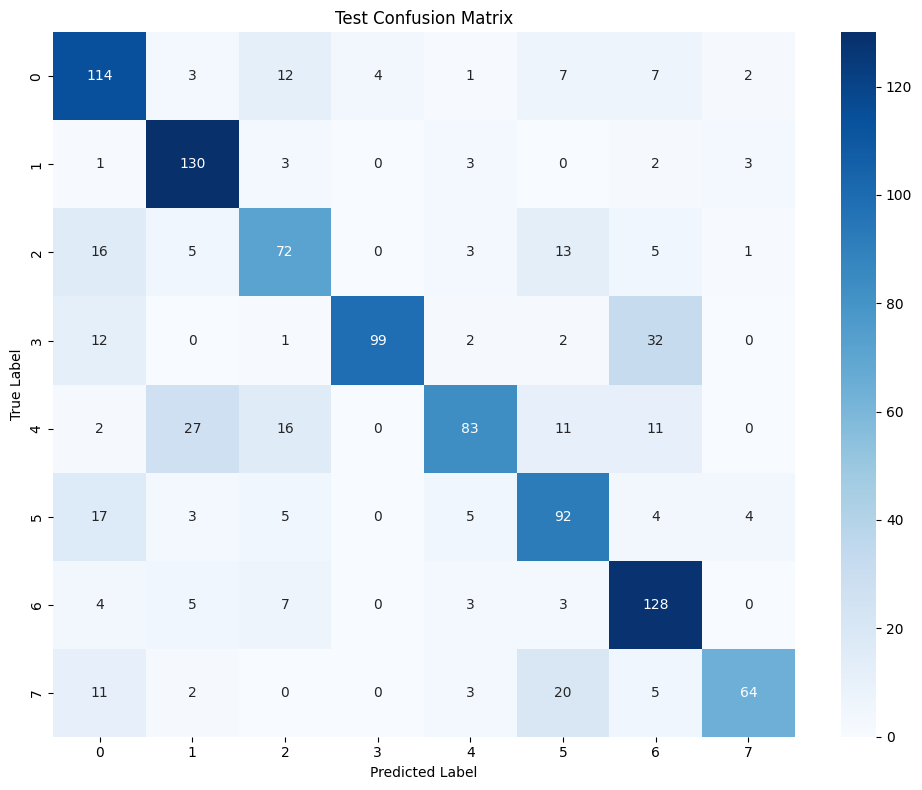

Testing DataLoader 0: 100%|██████████| 18/18 [00:13<00:00,  1.34it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7174311876296997     │
│        test_auroc         │    0.9465906620025635     │
│       test_f1_score       │    0.7133656144142151     │
│         test_loss         │     0.868735134601593     │
└───────────────────────────┴───────────────────────────┘


--- Confusion Matrix and Test Metrics ---
Error in metric computation: No samples to concatenate
Test Accuracy State: 0.0
Test F1 State: 0.0
Test AUROC State: None
Test Confusion Matrix State: None


/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassF1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAUROC was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


In [8]:
# Initialize the model with the desired ResNet version (can be changed as needed)
resnet_version = 'resnet152'  # Options: resnet18, resnet34, resnet50, resnet101, resnet152
lit_model = LitResNet4(garbage_classification_data.n_classes, resnet_version)

# Train the model
print(f"\n--- Starting training with {resnet_version} ---")
trainer.fit(model=lit_model, datamodule=garbage_classification_data)

# Test the model after training
print("\n--- Starting testing ---")
trainer.test(model=lit_model, datamodule=garbage_classification_data)

print("\n--- Confusion Matrix and Test Metrics ---")
lit_model.on_test_epoch_end()


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=34` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 18/18 [00:12<00:00,  1.39it/s]
--- Test Metrics ---
Accuracy: 0.7174
Macro F1 Score: 0.7134
AUROC: 0.9466


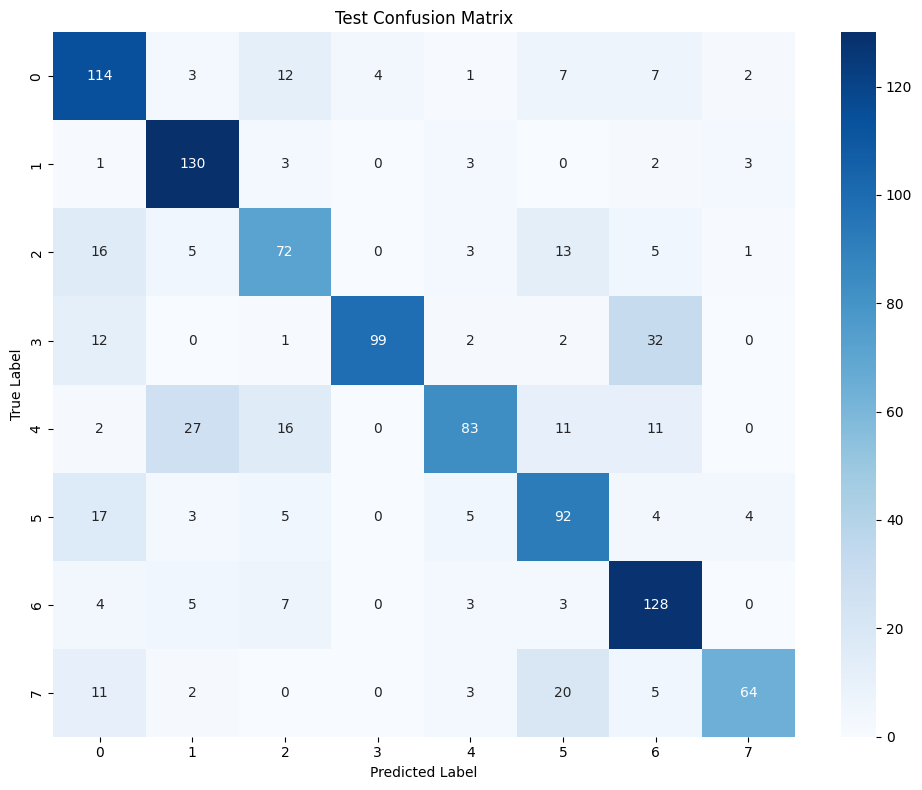

Testing DataLoader 0: 100%|██████████| 18/18 [00:13<00:00,  1.36it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7174311876296997     │
│        test_auroc         │    0.9465906620025635     │
│       test_f1_score       │    0.7133656144142151     │
│         test_loss         │     0.868735134601593     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.868735134601593,
  'test_accuracy': 0.7174311876296997,
  'test_f1_score': 0.7133656144142151,
  'test_auroc': 0.9465906620025635}]

In [11]:
lit_model.eval()
trainer.test(model=lit_model, datamodule=garbage_classification_data)


# TODO check if the model is being trained correctly
# TODO try to change the model saving method to torch.save